 Multi-Task NLP with LSTM

### Tasks:
#### 1. Emotion classification (emotions.csv)
#### 2. Gender-based violence type (Train.csv)
#### 3. Hate / offensive / neither (labeled_data.csv)

### Shared:
#### - Preprocessing
#### - Tokenizer
#### - Embedding + LSTM backbone

In [ ]:
import os
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
RANDOM_STATE = 42
MAX_VOCAB_SIZE = 20000
MAX_SEQUENCE_LEN = 60
TEST_SIZE = 0.2
BATCH_SIZE = 32
EPOCHS = 8

np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

### . Load datasets


In [ ]:
emotion_path = "emotions.csv"
violence_path = "Train.csv"
hate_path = "labeled_data.csv"

emotion_df = pd.read_csv(emotion_path)
violence_df = pd.read_csv(violence_path)
hate_df = pd.read_csv(hate_path)

print("Emotion:", emotion_df.shape)
print("Violence:", violence_df.shape)
print("Hate:", hate_df.shape)

Emotion: (416809, 3)
Violence: (39650, 3)
Hate: (24783, 7)


In [ ]:
# Emotion
if "emotion" in emotion_df.columns:
    emotion_df.rename(columns={"emotion": "label"}, inplace=True)
if "text" not in emotion_df.columns:
    # some versions use 'Content'
    if "Content" in emotion_df.columns:
        emotion_df.rename(columns={"Content": "text"}, inplace=True)

# Violence
if "tweet" in violence_df.columns:
    violence_df.rename(columns={"tweet": "text"}, inplace=True)
if "type" in violence_df.columns:
    violence_df.rename(columns={"type": "label"}, inplace=True)

# Hate speech
if "tweet" in hate_df.columns:
    hate_df.rename(columns={"tweet": "text"}, inplace=True)
if "class" in hate_df.columns:
    hate_df.rename(columns={"class": "label"}, inplace=True)

# keep only what we need for hate dataset
hate_df = hate_df[["text", "label"]]

print("Emotion cols:", emotion_df.columns)
print("Violence cols:", violence_df.columns)
print("Hate cols:", hate_df.columns)

Emotion cols: Index(['Unnamed: 0', 'text', 'label'], dtype='object')
Violence cols: Index(['Tweet_ID', 'text', 'label'], dtype='object')
Hate cols: Index(['text', 'label'], dtype='object')


###  Basic cleaning & align sizes


In [ ]:
def clean_basic(df):
    df = df.dropna(subset=["text", "label"]).copy()
    df["text"] = df["text"].astype(str).str.strip()
    df["label"] = df["label"].astype(str).str.strip()
    return df

emotion_df = clean_basic(emotion_df)
violence_df = clean_basic(violence_df)
hate_df = clean_basic(hate_df)

print("After drop NA:")
print("Emotion:", emotion_df.shape)
print("Violence:", violence_df.shape)
print("Hate:", hate_df.shape)

After drop NA:
Emotion: (416809, 3)
Violence: (39650, 3)
Hate: (24783, 2)


In [ ]:
# align sizes for multi-task (same number of rows)
min_size = min(len(emotion_df), len(violence_df), len(hate_df))
emotion_df = emotion_df.sample(min_size, random_state=RANDOM_STATE).reset_index(drop=True)
violence_df = violence_df.sample(min_size, random_state=RANDOM_STATE).reset_index(drop=True)
hate_df = hate_df.sample(min_size, random_state=RANDOM_STATE).reset_index(drop=True)

print("Aligned length:", min_size)

Aligned length: 24783


###  Text preprocessing


In [ ]:
nltk.download("stopwords")
nltk.download("punkt")

stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
def preprocess_text(text: str) -> str:
    text = str(text).lower()
    tokens = word_tokenize(text)
    filtered = [tok for tok in tokens if tok.isalpha() and tok not in stop_words]
    return " ".join(filtered)


In [ ]:
for df in [emotion_df, violence_df, hate_df]:
    df["clean_text"] = df["text"].apply(preprocess_text)

emotion_df[["text", "clean_text"]].head()

,text,clean_text
0,id say maybe made them feel foolish but that w...,id say maybe made feel foolish would reeeeeeal...
1,i joined the lds church i admit to feeling som...,joined lds church admit feeling somewhat asham...
2,i must admit i didnt feel like hugging him not...,must admit didnt feel like hugging angry disgu...
3,i hate that i can still feel if any nerve is d...,hate still feel nerve damaged badly enough oft...
4,im actually feeling a little smug,im actually feeling little smug


### Tokenizer & sequences (shared for all tasks)


In [ ]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")

all_texts = pd.concat(
    [emotion_df["clean_text"], violence_df["clean_text"], hate_df["clean_text"]],
    axis=0,
)
tokenizer.fit_on_texts(all_texts)

word_index = tokenizer.word_index
print("Vocab size:", len(word_index))

Vocab size: 50972


In [ ]:
def texts_to_padded(texts, max_len=MAX_SEQUENCE_LEN):
    seqs = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(seqs, maxlen=max_len, padding="post", truncating="post")
    return padded


In [ ]:
emotion_seq = texts_to_padded(emotion_df["clean_text"])
violence_seq = texts_to_padded(violence_df["clean_text"])
hate_seq = texts_to_padded(hate_df["clean_text"])

emotion_seq.shape, violence_seq.shape, hate_seq.shape

((24783, 60), (24783, 60), (24783, 60))

###  Encode labels (separate encoder for each task)


In [ ]:
def encode_labels(df, col="label"):
    le = LabelEncoder()
    y_ids = le.fit_transform(df[col])
    id2label = {i: lab for i, lab in enumerate(le.classes_)}
    return y_ids, le, id2label

In [ ]:
y_emotion, le_emotion, id2emotion = encode_labels(emotion_df)
y_violence, le_violence, id2violence = encode_labels(violence_df)
y_hate, le_hate, id2hate = encode_labels(hate_df)

print("Emotion classes:", id2emotion)
print("Violence classes:", id2violence)
print("Hate classes:", id2hate)

Emotion classes: {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5'}
Violence classes: {0: 'Harmful_Traditional_practice', 1: 'Physical_violence', 2: 'economic_violence', 3: 'emotional_violence', 4: 'sexual_violence'}
Hate classes: {0: '0', 1: '1', 2: '2'}


###  Train / validation split (shared indices)


In [ ]:
indices = np.arange(len(emotion_df))

train_idx, val_idx = train_test_split(
    indices,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y_emotion,   # stratify on one task
)

emo_train, emo_val = emotion_seq[train_idx], emotion_seq[val_idx]
vio_train, vio_val = violence_seq[train_idx], violence_seq[val_idx]
hate_train, hate_val = hate_seq[train_idx], hate_seq[val_idx]

y_emotion_train, y_emotion_val = y_emotion[train_idx], y_emotion[val_idx]
y_violence_train, y_violence_val = y_violence[train_idx], y_violence[val_idx]
y_hate_train, y_hate_val = y_hate[train_idx], y_hate[val_idx]

emo_train.shape, emo_val.shape

((19826, 60), (4957, 60))

###  Multi-task LSTM model


In [ ]:
vocab_size = min(MAX_VOCAB_SIZE, len(word_index) + 1)

# Inputs
inp_emo = keras.layers.Input(shape=(MAX_SEQUENCE_LEN,), name="emotion_input")
inp_vio = keras.layers.Input(shape=(MAX_SEQUENCE_LEN,), name="violence_input")
inp_hate = keras.layers.Input(shape=(MAX_SEQUENCE_LEN,), name="hate_input")

# Shared embedding + LSTM
emb = keras.layers.Embedding(vocab_size, 128, name="shared_embedding")

x_emo = emb(inp_emo)
x_vio = emb(inp_vio)
x_hate = emb(inp_hate)

shared_lstm = keras.layers.Bidirectional(
    keras.layers.LSTM(64, return_sequences=True),
    name="shared_bi_lstm",
)

x_emo = shared_lstm(x_emo)
x_vio = shared_lstm(x_vio)
x_hate = shared_lstm(x_hate)

gap = keras.layers.GlobalAveragePooling1D(name="shared_gap")
drop = keras.layers.Dropout(0.5, name="shared_dropout")

f_emo = drop(gap(x_emo))
f_vio = drop(gap(x_vio))
f_hate = drop(gap(x_hate))

n_emo = len(id2emotion)
n_vio = len(id2violence)
n_hate = len(id2hate)

out_emo = keras.layers.Dense(n_emo, activation="softmax", name="emotion_output")(f_emo)
out_vio = keras.layers.Dense(n_vio, activation="softmax", name="violence_output")(f_vio)
out_hate = keras.layers.Dense(n_hate, activation="softmax", name="hate_output")(f_hate)

model = keras.models.Model(
    inputs=[inp_emo, inp_vio, inp_hate],
    outputs=[out_emo, out_vio, out_hate],
)

model.compile(
    optimizer="adam",
    loss={
        "emotion_output": "sparse_categorical_crossentropy",
        "violence_output": "sparse_categorical_crossentropy",
        "hate_output": "sparse_categorical_crossentropy",
    },
    metrics={
        "emotion_output": "accuracy",
        "violence_output": "accuracy",
        "hate_output": "accuracy",
    },
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ emotion_input       │ (None, 60)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ violence_input      │ (None, 60)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hate_input          │ (None, 60)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_embedding    │ (None, 60, 128)   │  2,560,000 │ emotion_input[0]… │
│ (Embedding)         │                   │            │ violence_input[0… │
│                     │                   │            │ hate_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_bi_lstm      │ (None, 60, 128)   │     98,816 │ shared_embedding… │
│ (Bidirectional)     │                   │            │ shared_embedding… │
│                     │                   │            │ shared_embedding… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_gap          │ (None, 128)       │          0 │ shared_bi_lstm[0… │
│ (GlobalAveragePool… │                   │            │ shared_bi_lstm[1… │
│                     │                   │            │ shared_bi_lstm[2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_dropout      │ (None, 128)       │          0 │ shared_gap[0][0], │
│ (Dropout)           │                   │            │ shared_gap[1][0], │
│                     │                   │            │ shared_gap[2][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emotion_output      │ (None, 6)         │        774 │ shared_dropout[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ violence_output     │ (None, 5)         │        645 │ shared_dropout[1… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hate_output (Dense) │ (None, 3)         │        387 │ shared_dropout[2… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,660,622 (10.15 MB)

 Trainable params: 2,660,622 (10.15 MB)

 Non-trainable params: 0 (0.00 B)

### Train


In [ ]:
history = model.fit(
    x={
        "emotion_input": emo_train,
        "violence_input": vio_train,
        "hate_input": hate_train,
    },
    y={
        "emotion_output": y_emotion_train,
        "violence_output": y_violence_train,
        "hate_output": y_hate_train,
    },
    validation_data=(
        {
            "emotion_input": emo_val,
            "violence_input": vio_val,
            "hate_input": hate_val,
        },
        {
            "emotion_output": y_emotion_val,
            "violence_output": y_violence_val,
            "hate_output": y_hate_val,
        },
    ),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
)

Epoch 1/8
620/620 ━━━━━━━━━━━━━━━━━━━━ 181s 274ms/step - emotion_output_accuracy: 0.3410 - emotion_output_loss: 1.6036 - hate_output_accuracy: 0.7833 - hate_output_loss: 0.6388 - loss: 2.6727 - violence_output_accuracy: 0.8852 - violence_output_loss: 0.4302 - val_emotion_output_accuracy: 0.5185 - val_emotion_output_loss: 1.2647 - val_hate_output_accuracy: 0.8804 - val_hate_output_loss: 0.3677 - val_loss: 1.7340 - val_violence_output_accuracy: 0.9667 - val_violence_output_loss: 0.1019
Epoch 2/8
620/620 ━━━━━━━━━━━━━━━━━━━━ 187s 249ms/step - emotion_output_accuracy: 0.5945 - emotion_output_loss: 1.1113 - hate_output_accuracy: 0.8839 - hate_output_loss: 0.3555 - loss: 1.5563 - violence_output_accuracy: 0.9727 - violence_output_loss: 0.0896 - val_emotion_output_accuracy: 0.7434 - val_emotion_output_loss: 0.7443 - val_hate_output_accuracy: 0.8737 - val_hate_output_loss: 0.3556 - val_loss: 1.1550 - val_violence_output_accuracy: 0.9822 - val_violence_output_loss: 0.0553
Epoch 3/8
620/620 ━━━━

### Evaluation per task


In [ ]:
pred_emo_val, pred_vio_val, pred_hate_val = model.predict(
    {
        "emotion_input": emo_val,
        "violence_input": vio_val,
        "hate_input": hate_val,
    }
)

y_pred_emo = np.argmax(pred_emo_val, axis=1)
y_pred_vio = np.argmax(pred_vio_val, axis=1)
y_pred_hate = np.argmax(pred_hate_val, axis=1)

155/155 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step


In [ ]:
def eval_task(y_true, y_pred, id2label, title):
    print(f"\n===== {title} =====")
    print(
        classification_report(
            y_true,
            y_pred,
            target_names=[id2label[i] for i in sorted(id2label.keys())],
        )
    )
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=[id2label[i] for i in sorted(id2label.keys())],
        yticklabels=[id2label[i] for i in sorted(id2label.keys())],
    )
    plt.title(f"{title} – Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


===== Emotion =====
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      1423
           1       0.91      0.92      0.92      1686
           2       0.79      0.77      0.78       409
           3       0.89      0.90      0.89       686
           4       0.85      0.84      0.84       578
           5       0.69      0.72      0.71       175

    accuracy                           0.89      4957
   macro avg       0.85      0.85      0.85      4957
weighted avg       0.89      0.89      0.89      4957



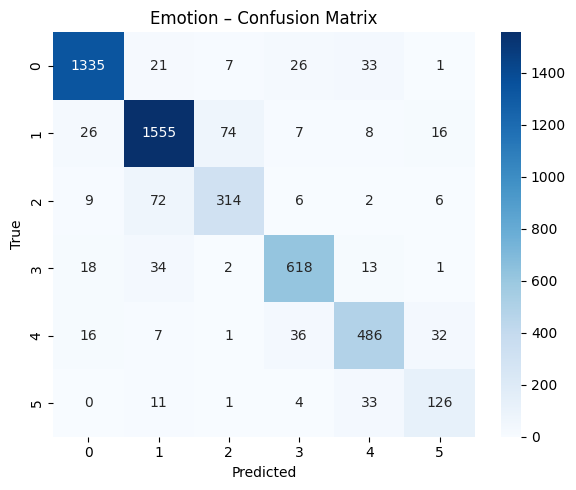


===== Violence =====
                              precision    recall  f1-score   support

Harmful_Traditional_practice       0.91      0.91      0.91        22
           Physical_violence       0.99      0.99      0.99       745
           economic_violence       0.79      0.93      0.85        28
          emotional_violence       0.80      0.90      0.85        81
             sexual_violence       1.00      0.99      1.00      4081

                    accuracy                           0.99      4957
                   macro avg       0.90      0.95      0.92      4957
                weighted avg       0.99      0.99      0.99      4957



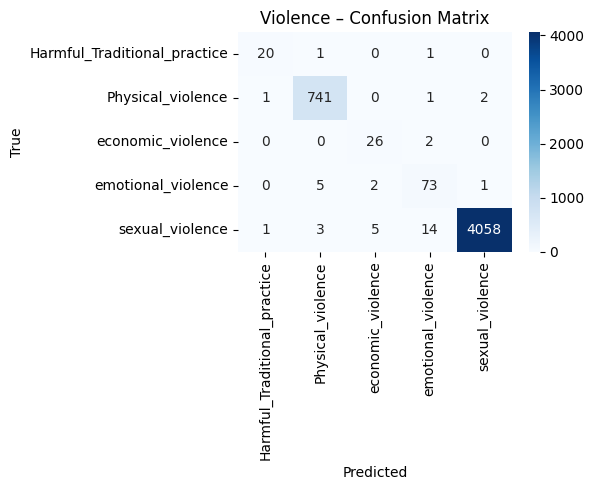


===== Hate / Offensive =====
              precision    recall  f1-score   support

           0       0.39      0.26      0.31       278
           1       0.90      0.95      0.93      3815
           2       0.84      0.74      0.79       864

    accuracy                           0.87      4957
   macro avg       0.71      0.65      0.67      4957
weighted avg       0.86      0.87      0.87      4957



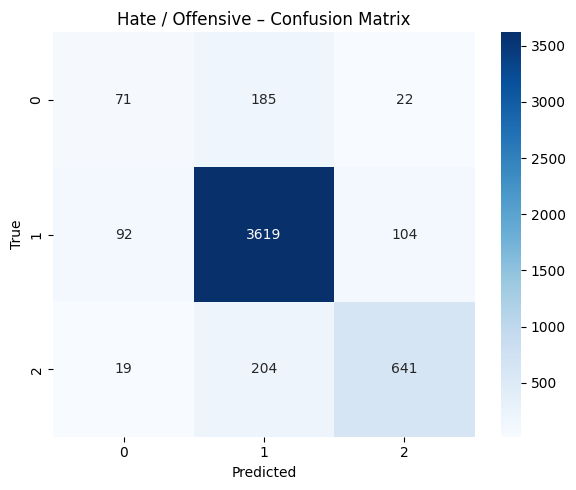

In [ ]:
eval_task(y_emotion_val, y_pred_emo, id2emotion, "Emotion")
eval_task(y_violence_val, y_pred_vio, id2violence, "Violence")
eval_task(y_hate_val, y_pred_hate, id2hate, "Hate / Offensive")

### Inference helper


In [ ]:
def predict_all(text: str):
    cleaned = preprocess_text(text)
    seq = texts_to_padded([cleaned])

    p_emo, p_vio, p_hate = model.predict(
        {
            "emotion_input": seq,
            "violence_input": seq,
            "hate_input": seq,
        }
    )

    emo_idx = int(np.argmax(p_emo, axis=1)[0])
    vio_idx = int(np.argmax(p_vio, axis=1)[0])
    hate_idx = int(np.argmax(p_hate, axis=1)[0])

    return {
        "text": text,
        "cleaned": cleaned,
        "emotion": id2emotion[emo_idx],
        "violence": id2violence[vio_idx],
        "hate": id2hate[hate_idx],
    }

predict_all("He insulted her in public and threatened to hurt her again.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


{'text': 'He insulted her in public and threatened to hurt her again.',
 'cleaned': 'insulted public threatened hurt',
 'emotion': '4',
 'violence': 'emotional_violence',
 'hate': '2'}

###  Save model & assets (for Streamlit)


In [ ]:
import json
import pickle

os.makedirs("models", exist_ok=True)

# model
model.save("models/multitask_lstm.h5")

# tokenizer
with open("models/tokenizer.json", "w", encoding="utf-8") as f:
    f.write(tokenizer.to_json())

# label maps
label_maps = {
    "emotion": id2emotion,
    "violence": id2violence,
    "hate": id2hate,
}
with open("models/label_maps.pkl", "wb") as f:
    pickle.dump(label_maps, f)

print("Saved model + tokenizer + label maps in /models")

Saved model + tokenizer + label maps in /models
